In [1]:
%run C:/Users/Hamid/SincNet_parkinson/data_io.ipynb
%run C:/Users/Hamid/SincNet_parkinson/dnn_models.ipynb

In [2]:


import pickle
import os
#import scipy.io.wavfile
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import librosa
from sklearn.model_selection import StratifiedKFold
import noisereduce as nr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sys
import numpy as np

parkinson_path = 'audio/italian/npy/parkinson'
healthy_path = 'audio/italian/npy/healthy_control'
labels_path = 'audio/italian/npy/labels'
data_path = 'audio/italian/npy/audio_list'


def create_batches_rnd(batch_size,wlen,fact_amp):
    
 # Initialization of the minibatch (batch_size,[0=>x_t,1=>x_t+N,1=>random_samp])
    sig_batch = np.zeros([batch_size, wlen])
    lab_batch = np.zeros(batch_size)  
    snt_id_arr=np.random.randint(train_len, size=batch_size)
    rand_amp_arr = np.random.uniform(1.0-fact_amp,1+fact_amp,batch_size)

    for i in range(batch_size):
        signal = data_train[snt_id_arr[i]]
        snt_len = signal.shape[0]
        channels = len(signal.shape)
        if channels == 2:
            print('WARNING: stereo to mono: '+data_folder+wav_lst[snt_id_arr[i]])
            signal = signal[:,0]
        snt_beg=np.random.randint(snt_len-wlen-1) #randint(0, snt_len-2*wlen-1)
        snt_end=snt_beg+wlen
        sig_batch[i,:]=signal[snt_beg:snt_end]*rand_amp_arr[i]
        lab_batch[i]=labels_train[snt_id_arr[i]]

    inp=Variable(torch.from_numpy(sig_batch).float().cuda().contiguous())
    lab=Variable(torch.from_numpy(lab_batch).float().cuda().contiguous())
  
    return inp,lab  






dataset_type = 'italian_dataset'


# Open the file in read-binary mode and load the audio_list from the file
with open(data_path, 'rb') as f:
    audio_list = pickle.load(f)

# Open the file in read-binary mode and load the labels from the file
with open(labels_path, 'rb') as f:
    labels = pickle.load(f)

# Reading cfg files
options=read_conf(dataset_type)

 

# Accessing parameters from the options dictionary
pt_file = options['pt_file']
class_dict_file = options['lab_dict']
output_folder=options['output_folder']

# [windowing]
fs = int(options['fs'])
cw_len = int(options['cw_len'])
cw_shift = int(options['cw_shift'])

# [cnn]
cnn_N_filt = list(map(int, options['cnn_N_filt'].split(',')))
cnn_len_filt = list(map(int, options['cnn_len_filt'].split(',')))
cnn_max_pool_len = list(map(int, options['cnn_max_pool_len'].split(',')))
cnn_use_laynorm_inp = str_to_bool(options['cnn_use_laynorm_inp'])
cnn_use_batchnorm_inp = str_to_bool(options['cnn_use_batchnorm_inp'])
cnn_use_laynorm = list(map(str_to_bool, options['cnn_use_laynorm'].split(',')))
cnn_use_batchnorm = list(map(str_to_bool, options['cnn_use_batchnorm'].split(',')))
cnn_act = list(map(str, options['cnn_act'].split(',')))
cnn_drop = list(map(float, options['cnn_drop'].split(',')))

# [dnn]
fc_lay = list(map(int, options['fc_lay'].split(',')))
fc_drop = list(map(float, options['fc_drop'].split(',')))
fc_use_laynorm_inp = str_to_bool(options['fc_use_laynorm_inp'])
fc_use_batchnorm_inp = str_to_bool(options['fc_use_batchnorm_inp'])
fc_use_batchnorm = list(map(str_to_bool, options['fc_use_batchnorm'].split(',')))
fc_use_laynorm = list(map(str_to_bool, options['fc_use_laynorm'].split(',')))
fc_act = list(map(str, options['fc_act'].split(',')))

# [class]
class_lay = list(map(int, options['class_lay'].split(',')))
class_drop = list(map(float, options['class_drop'].split(',')))
class_use_laynorm_inp = str_to_bool(options['class_use_laynorm_inp'])
class_use_batchnorm_inp = str_to_bool(options['class_use_batchnorm_inp'])
class_use_batchnorm = list(map(str_to_bool, options['class_use_batchnorm'].split(',')))
class_use_laynorm = list(map(str_to_bool, options['class_use_laynorm'].split(',')))
class_act = list(map(str, options['class_act'].split(',')))

# [optimization]
lr = float(options['lr'])
batch_size = int(options['batch_size'])
N_epochs = 25
N_batches = 200
N_eval_epoch = int(options['N_eval_epoch'])
seed = int(options['seed'])


# Folder creation
try:
    os.stat(output_folder)
except:
    os.mkdir(output_folder) 
    
    

# loss function

  
# Converting context and shift in samples
wlen=int(fs*cw_len/1000.00)
wshift=int(fs*cw_shift/1000.00)

# Batch_dev
Batch_dev=128


# Feature extractor CNN




speakers = np.array(list(audio_list.keys()))
labels = np.array(labels)
n_fold = 4
skf = StratifiedKFold(n_splits=n_fold)  # 5 is an example, replace with the number of splits you want
acuuracy_tot = 0

precision_tot = 0

recall_tot = 0

C:\Users\Hamid\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
for train_index, test_index in skf.split(speakers, labels):
    speaker_train, speaker_test = speakers[train_index], speakers[test_index]
    data_train = [audio for speaker in speaker_train for audio in audio_list[speaker]]
    data_test = [audio for speaker in speaker_test for audio in audio_list[speaker]]
    labels_train = [labels[speaker-1] for speaker in speaker_train for _ in audio_list[speaker]]
    labels_test =  [labels[speaker-1] for speaker in speaker_test for _ in audio_list[speaker]]
    data_train, data_valid, labels_train, labels_valid = train_test_split(data_train, labels_train, test_size=0.2, random_state=42)
    history_val_acc= []
    history_val_loss= []
    history_train_acc= []
    history_train_loss= []

    torch.manual_seed(seed)
    np.random.seed(seed)

    cost = nn.NLLLoss()

    CNN_arch = {'input_dim': wlen,
              'fs': fs,
              'cnn_N_filt': cnn_N_filt,
              'cnn_len_filt': cnn_len_filt,
              'cnn_max_pool_len':cnn_max_pool_len,
              'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
              'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
              'cnn_use_laynorm':cnn_use_laynorm,
              'cnn_use_batchnorm':cnn_use_batchnorm,
              'cnn_act': cnn_act,
              'cnn_drop':cnn_drop,          
              }


    CNN_net=SincNet(CNN_arch)
    CNN_net.cuda()


    DNN1_arch = {'input_dim': CNN_net.out_dim,
              'fc_lay': fc_lay,
              'fc_drop': fc_drop, 
              'fc_use_batchnorm': fc_use_batchnorm,
              'fc_use_laynorm': fc_use_laynorm,
              'fc_use_laynorm_inp': fc_use_laynorm_inp,
              'fc_use_batchnorm_inp':fc_use_batchnorm_inp,
              'fc_act': fc_act,
              }

    DNN1_net=MLP(DNN1_arch)
    DNN1_net.cuda()

    DNN2_arch = {'input_dim':fc_lay[-1] ,
              'fc_lay': class_lay,
              'fc_drop': class_drop, 
              'fc_use_batchnorm': class_use_batchnorm,
              'fc_use_laynorm': class_use_laynorm,
              'fc_use_laynorm_inp': class_use_laynorm_inp,
              'fc_use_batchnorm_inp':class_use_batchnorm_inp,
              'fc_act': class_act,
              }


    DNN2_net=MLP(DNN2_arch)
    DNN2_net.cuda()





    if pt_file!='none':
       checkpoint_load = torch.load(pt_file)
       CNN_net.load_state_dict(checkpoint_load['CNN_model_par'])
       DNN1_net.load_state_dict(checkpoint_load['DNN1_model_par'])
       DNN2_net.load_state_dict(checkpoint_load['DNN2_model_par'])

    optimizer_CNN = optim.RMSprop(CNN_net.parameters(), lr=lr,alpha=0.95, eps=1e-8) 
    optimizer_DNN1 = optim.RMSprop(DNN1_net.parameters(), lr=lr,alpha=0.95, eps=1e-8) 
    optimizer_DNN2 = optim.RMSprop(DNN2_net.parameters(), lr=lr,alpha=0.95, eps=1e-8) 
    




    train_len = len(data_train)
    test_len  = len(data_test)
    valid_len = len(data_valid)
    for epoch in range(N_epochs):
      test_flag=0
      CNN_net.train()
      DNN1_net.train()
      DNN2_net.train()

      loss_sum = 0
      accuracy_sum = 0
      for i in range(N_batches):

        [inp,lab]=create_batches_rnd(batch_size,wlen,0.2)
        pout=DNN2_net(DNN1_net(CNN_net(inp)))

        pred=torch.max(pout,dim=1)[1]
        loss = cost(pout, lab.long())
        accuracy_train = torch.mean((pred==lab.long()).float())


        optimizer_CNN.zero_grad()
        optimizer_DNN1.zero_grad() 
        optimizer_DNN2.zero_grad() 

        loss.backward()
        optimizer_CNN.step()
        optimizer_DNN1.step()
        optimizer_DNN2.step()

        loss_sum=loss_sum + loss.detach()
        accuracy_sum=accuracy_sum + accuracy_train.detach()


      loss_tot=loss_sum/N_batches
      accuracy_train_res = accuracy_sum/N_batches
      history_train_acc.append(accuracy_train_res)
      history_train_loss.append(loss_tot)

      CNN_net.eval()
      DNN1_net.eval()
      DNN2_net.eval()
      loss_sum = 0
      accuracy_val = 0
      with torch.no_grad():  

        for i in range(valid_len):
         signal = torch.from_numpy(data_valid[i]).float().cuda().contiguous()

         lab_batch = labels_valid[i]

         beg_samp = 0
         end_samp=wlen

         N_fr=int((signal.shape[0]-wlen)/(wshift))

         sig_arr=torch.zeros([Batch_dev,wlen]).float().cuda().contiguous()
         lab= Variable((torch.zeros(N_fr+1)+lab_batch).cuda().contiguous().long())
         pout=Variable(torch.zeros(N_fr+1,class_lay[-1]).cuda().float().contiguous())
         count_fr=0
         count_fr_tot=0
         while end_samp<signal.shape[0]:
             sig_arr[count_fr,:]=signal[beg_samp:end_samp]
             beg_samp=beg_samp+wshift
             end_samp=beg_samp+wlen
             count_fr=count_fr+1
             count_fr_tot=count_fr_tot+1
             if count_fr==Batch_dev:
                 inp=Variable(sig_arr)
                 pout[count_fr_tot-Batch_dev:count_fr_tot,:]=DNN2_net(DNN1_net(CNN_net(inp)))
                 count_fr=0
                 sig_arr=torch.zeros([Batch_dev,wlen]).float().cuda().contiguous()


        # if count_fr>0:
          #inp = Variable(sig_arr[0:count_fr])
         # pout[count_fr_tot-count_fr:count_fr_tot,:] = DNN2_net(DNN1_net(CNN_net(inp)))

         [val_validation,best_class] = torch.max(torch.sum(pout,dim=0),0)
         accuracy_val = accuracy_val + (best_class==lab[0]).float()
         loss_sum=loss_sum+loss.detach()
            
        loss_tot_dev = loss_sum/valid_len 
        accuracy_val_res = accuracy_val/valid_len
        history_val_acc.append(accuracy_val_res)
        history_val_loss.append(loss_tot_dev)


      if epoch==N_epochs-1:
      
       test_flag = 1 
       true_positives = 0
       false_positives = 0
       false_negatives = 0
       accuracy_te = 0

       with torch.no_grad():  

        for i in range(test_len):
         signal = torch.from_numpy(data_test[i]).float().cuda().contiguous()

         lab_batch = labels_test[i]

         # split signals into chunks
         beg_samp = 0
         end_samp=wlen

         N_fr=int((signal.shape[0]-wlen)/(wshift))

         sig_arr=torch.zeros([Batch_dev,wlen]).float().cuda().contiguous()
         lab= Variable((torch.zeros(N_fr+1)+lab_batch).cuda().contiguous().long())
         pout=Variable(torch.zeros(N_fr+1,class_lay[-1]).cuda().float().contiguous())
         count_fr=0
         count_fr_tot=0
         while end_samp<signal.shape[0]:
             sig_arr[count_fr,:]=signal[beg_samp:end_samp]
             beg_samp=beg_samp+wshift
             end_samp=beg_samp+wlen
             count_fr=count_fr+1
             count_fr_tot=count_fr_tot+1
             if count_fr==Batch_dev:
                 inp=Variable(sig_arr)
                 pout[count_fr_tot-Batch_dev:count_fr_tot,:]=DNN2_net(DNN1_net(CNN_net(inp)))
                 count_fr=0
                 sig_arr=torch.zeros([Batch_dev,wlen]).float().cuda().contiguous()


        # if count_fr>0:
          #inp = Variable(sig_arr[0:count_fr])
         # pout[count_fr_tot-count_fr:count_fr_tot,:] = DNN2_net(DNN1_net(CNN_net(inp)))

         [val,best_class] = torch.max(torch.sum(pout,dim=0),0)
         accuracy_te = accuracy_te + (best_class==lab[0]).float()
         

         
         true_positives += ((best_class == 1) & (lab[0] == 1))
         false_positives += ((best_class == 1) & (lab[0] == 0))
         false_negatives += ((best_class == 0) & (lab[0] == 1))

        # Avoid division by zero
        precision = true_positives / max(true_positives + false_positives, 1)
        recall = true_positives / max(true_positives + false_negatives, 1)
        accuracy_te_res = accuracy_te/test_len
        loss_tot_dev = loss_sum/test_len 
        acuuracy_tot +=  accuracy_te_res
        precision_tot += precision
        recall_tot += recall
    
       print("epoch %i, accuracy_test=%f precision=%f recall=%f"  % (epoch, accuracy_te_res, precision, recall))
       print("accuracy_test=%f precision=%f recall=%f"  % (accuracy_te_res, precision, recall))

       with open(output_folder+"/res.res", "a") as res_file:
        res_file.write("epoch %i,accuracy_test=%f precision=%f recall=%f"  % (epoch, accuracy_te_res, precision, recall))


       checkpoint={'CNN_model_par': CNN_net.state_dict(),
                   'DNN1_model_par': DNN1_net.state_dict(),
                   'DNN2_model_par': DNN2_net.state_dict(),
                   }
       torch.save(checkpoint,output_folder+'/model_raw.pkl')

      else:
       print("epoch %i, loss_tr=%f accuracy=%f loss_val=%f accuracy_val=%f" % (epoch, loss_tot , accuracy_train_res,loss_tot_dev,accuracy_val_res))
acuuracy_tot=acuuracy_tot/n_fold
recall_tot = recall_tot/n_fold
precision_tot = precision_tot/n_fold
print("mean of k fold: accuracy_test=%f precision=%f recall=%f"  % (acuuracy_tot, precision_tot, recall_tot))


epoch 0, loss_tr=0.476363 accuracy=0.759727 loss_val=0.102012 accuracy_val=1.000000
epoch 1, loss_tr=0.118015 accuracy=0.954219 loss_val=0.058123 accuracy_val=1.000000
epoch 2, loss_tr=0.078650 accuracy=0.971797 loss_val=0.047724 accuracy_val=1.000000
epoch 3, loss_tr=0.059691 accuracy=0.978555 loss_val=0.006907 accuracy_val=1.000000
epoch 4, loss_tr=0.047284 accuracy=0.983281 loss_val=0.027651 accuracy_val=1.000000
epoch 5, loss_tr=0.036269 accuracy=0.987852 loss_val=0.013108 accuracy_val=1.000000
epoch 6, loss_tr=0.034172 accuracy=0.988672 loss_val=0.016782 accuracy_val=1.000000
epoch 7, loss_tr=0.029390 accuracy=0.990156 loss_val=0.053926 accuracy_val=1.000000
epoch 8, loss_tr=0.026976 accuracy=0.990898 loss_val=0.016683 accuracy_val=1.000000
epoch 9, loss_tr=0.025740 accuracy=0.991445 loss_val=0.023049 accuracy_val=1.000000
epoch 10, loss_tr=0.021769 accuracy=0.992461 loss_val=0.051114 accuracy_val=1.000000
epoch 11, loss_tr=0.020521 accuracy=0.992773 loss_val=0.026063 accuracy_val

epoch 21, loss_tr=0.084560 accuracy=0.954922 loss_val=0.080407 accuracy_val=1.000000
epoch 22, loss_tr=0.091505 accuracy=0.952422 loss_val=0.082763 accuracy_val=1.000000
epoch 23, loss_tr=0.085923 accuracy=0.955352 loss_val=0.096951 accuracy_val=1.000000
epoch 24, accuracy_test=1.000000 precision=1.000000 recall=1.000000
accuracy_test=1.000000 precision=1.000000 recall=1.000000
mean of k fold: accuracy_test=0.912692 precision=0.904167 recall=0.923077


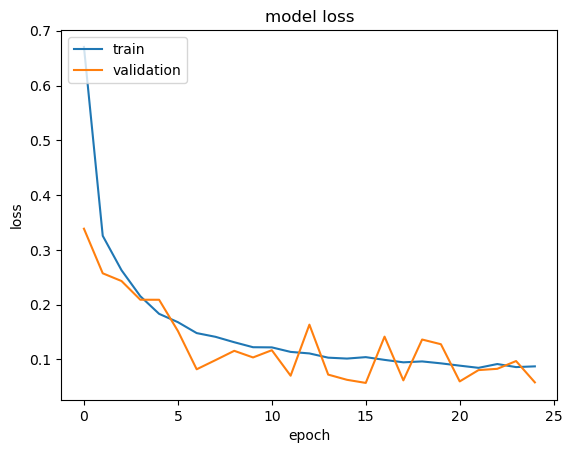

In [7]:
history_val_loss_cpu = torch.Tensor(history_val_loss).cpu().numpy()
history_train_loss_cpu = torch.Tensor(history_train_loss).cpu().numpy()
plt.plot(history_train_loss_cpu)
plt.plot(history_val_loss_cpu)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

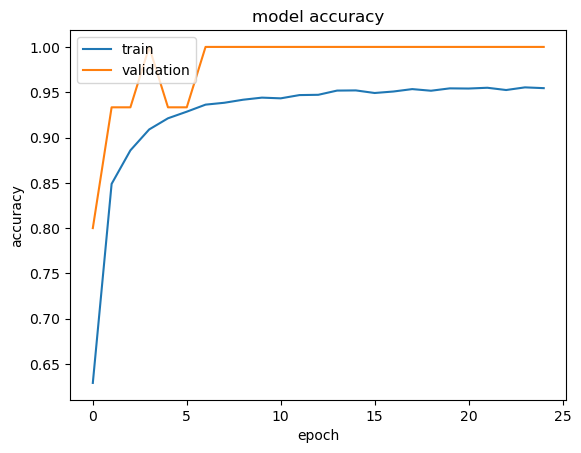

In [8]:
history_val_acc_cpu = torch.Tensor(history_val_acc).cpu().numpy()
history_train_acc_cpu = torch.Tensor(history_train_acc).cpu().numpy()
plt.plot(history_train_acc_cpu)
plt.plot(history_val_acc_cpu)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()